<h1><center>Predicting Internal Migration in China at City Level</center></h1>
<h3><center>Group 8: Qinfei Chen (qc483) & Jiang Shuo (sj2323)</center></h3>


In [42]:
import numpy as np                  
import pandas as pd
import geopandas as gpd

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import randint
from scipy.stats import uniform

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import AutoMinorLocator
import matplotlib.colors as colors
import matplotlib.patches as mpatches

import mapclassify as mc

import tensorflow as tf

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras import optimizers


%matplotlib inline

<h2>A. Data Loading and Description</h2>

In [5]:
df=pd.read_csv("migration_net_flow_at_city_level.csv")

df=df.sort_values(by="Year_T") #Since the dataset is time series, we sort it by year.


In [6]:
# scale the variables

df['Net_Flow_T+1'] = df['Net_Flow_T+1']*100
df['Unempl_Rate'] = df['Unempl_Rate']*100
df['Prop_in_Sec_Ind'] = df['Prop_in_Sec_Ind']*100
df['GRP_Growth'] = df["GRP_Growth"]*100
df['Prop_of_Sci_Exp'] = df["Prop_of_Sci_Exp"]*100
df['Prop_of_Edu_Exp'] = df["Prop_of_Edu_Exp"]*100


In [7]:
df.head()

,City_Name,Year_T,Unempl_Rate,Prop_in_Sec_Ind,Pop_Density,GRP,GRP_Growth,Prop_of_Sci_Exp,Prop_of_Edu_Exp,Num_of_School,Avg_Income,Net_Flow_T+1
0,Quzhou,1997,1.1,22.3,270.0,1334083,5.7,0.2,14.9,1,7026.0,-0.12
125,Qingdao,1997,0.6,35.5,653.0,7977025,12.0,0.1,8.9,4,7030.0,-0.07
126,Yinchuan,1997,1.3,31.1,265.0,754963,9.9,0.3,13.1,4,5860.0,1.27
127,Tianshui,1997,1.3,16.6,227.0,611920,-4.2,0.4,20.8,1,4536.0,0.41
128,Baiyin,1997,1.3,22.0,79.0,590030,10.6,0.3,11.3,0,6732.0,1.21



<h3>1. X Variables (Features) Description</h3>
<br>
<b>11 features</b> in total, including: <br>
(a) <b>"City_Name"</b><br>
(b) <b>"Year_T" </b> — Year <b>T</b> <br> 
(c) <b>"Unempl_Rate"</b> — unemployment rate at city level in percentage (%) <br>
(d) <b>"Prop_in_Sec_Ind"</b> — proportion of people working in secondary industry at city level in percentage(%) <br>
(e) <b>"Pop_Density"</b> — population density at city level (person/sq.km) <br>
(f) <b>"GRP"</b> — gross regional product of city (10,000 yuan) <br>
(g) <b>"GRP_Growth"</b> — GRP growth rate in percentage (%) <br>
(h) <b>"Prop_of_Sci_Exp"</b> — proportion of science expenditure in public finance expenditure at city level in percentage (%) <br>
(i) <b>"Prop_of_Edu_Exp"</b> — proportion of education expenditure in public finance expenditure at city level in percentage (%) <br>
(j) <b>"Num_of_School"</b> — number of regular institutions of higher education in city <br>
(k) <b>"Avg_Income"</b> — average income of employed workers in city (yuan) <br>

<h3>2. Y Description</h3><br>
<b> Net_Flow_T+1</b> — proportion of migration net flow at city level in <b>T+1</b> year (%)<br>

Since there is <b> no direct record </b> of it, it is calculated based on the formula: $Y_{t+1}=\frac{\Delta P_{t,t+1}-P_{t}\times g_{t+1}}{P_{t}}$ (P - city population; g - nautual growth rate) <br><br>
<b> There are no X features involved for the calculation of Y</b>

<br>

All the data are manually collected from <i><b> China City Statistical Yearbook 2007-2016</b></i> which can be accessed from [this link](http://tongji.cnki.net/kns55/Navi/HomePage.aspx?id=N2012020070&name=YZGCA&floor=1).


<h3>3. Summary Statistics </h3>

In [8]:
df.describe() # show the range for each X features and Y including mean, max, sd and quantile

,Year_T,Unempl_Rate,Prop_in_Sec_Ind,Pop_Density,GRP,GRP_Growth,Prop_of_Sci_Exp,Prop_of_Edu_Exp,Num_of_School,Avg_Income,Net_Flow_T+1
count,4563.000000,4563.000000,4563.000000,4563.000000,4.563000e+03,4563.000000,4563.000000,4563.000000,4563.000000,4563.000000,4563.000000
mean,2006.349332,3.543393,43.178260,445.123545,1.098525e+07,12.259478,2.091497,16.481153,6.614070,23491.070640,0.081799
std,5.306667,2.553729,13.849167,404.181580,1.758916e+07,16.586856,4.675222,6.530352,11.800748,16055.404187,0.570709
min,1997.000000,0.100000,4.500000,4.720000,1.604500e+05,-40.500000,0.100000,0.100000,0.000000,2715.000000,-1.970000
25%,2002.000000,2.200000,32.900000,189.910000,2.522091e+06,9.500000,0.400000,12.900000,1.000000,10022.075000,-0.200000
50%,2006.000000,3.200000,43.000000,370.000000,5.505542e+06,12.100000,0.700000,17.000000,3.000000,18779.710000,0.050000
75%,2011.000000,4.300000,52.500000,620.345000,1.202920e+07,14.200000,1.500000,20.800000,5.000000,34774.415000,0.370000
max,2015.000000,49.700000,84.400000,5935.000000,2.133083e+08,790.500000,41.400000,49.400000,91.000000,137085.580000,1.980000


In [9]:
df.groupby(["Year_T"])["City_Name"].count() #show the number of observations each year

Year_T
1997    196
1998    193
1999    196
2000    210
2001    234
2002    241
2003    256
2004    253
2005    259
2006    256
2007    263
2008    264
2009    242
2010    257
2011    257
2012    250
2013    252
2014    249
2015    235
Name: City_Name, dtype: int64

In [10]:
df.groupby(["City_Name"])["Net_Flow_T+1"].count()[:10] #show the number of observations for the first 10 cities

City_Name
Ankang      15
Anqing      18
Anshan      19
Anshun      14
Anyang      19
Baicheng    19
Baise       11
Baishan     16
Baiyin      14
Baoding     19
Name: Net_Flow_T+1, dtype: int64

<br>
There are 4563 observation in total starting from 1997 to 2015. Since we drop the cities that have missing values and not all the cities are recorded in the statistical yearbook, the number of observations vary by year and by cities. 

<h2>B. Data Visualization </h2>

<h3>1. Distribution of Y</h3>

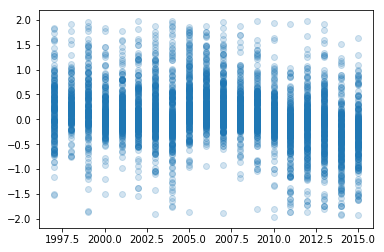

In [11]:
plt.scatter(df["Year_T"],df["Net_Flow_T+1"],alpha=0.2)

In [12]:
df.groupby("Year_T")["Net_Flow_T+1"].mean()

Year_T
1997    0.196480
1998    0.235596
1999    0.242704
2000    0.141286
2001    0.146538
2002    0.122905
2003    0.149766
2004    0.041581
2005    0.348687
2006    0.373945
2007    0.278099
2008    0.181098
2009    0.186364
2010    0.067432
2011   -0.212529
2012   -0.122000
2013   -0.100040
2014   -0.372169
2015   -0.285787
Name: Net_Flow_T+1, dtype: float64

In [13]:
df.groupby("Year_T")["Net_Flow_T+1"].var()

Year_T
1997    0.355729
1998    0.166892
1999    0.424509
2000    0.210103
2001    0.189394
2002    0.274857
2003    0.328258
2004    0.415084
2005    0.334919
2006    0.225203
2007    0.231610
2008    0.170110
2009    0.221236
2010    0.198189
2011    0.276351
2012    0.340618
2013    0.387212
2014    0.341582
2015    0.311475
Name: Net_Flow_T+1, dtype: float64

In [16]:
fp = "China_Geo_Code/CHN_adm2.shp" #downloaded from DIVA-GIS

map_df = gpd.read_file(fp)[["NAME_2","geometry"]]

map_df = map_df.rename(index=str, columns={"NAME_2": "City_Name"}) #change the name of column for merging

#map_df.head()

Source: The geo map code data of China comes from [DIVA-GIS](http://www.diva-gis.org/gdata) which is free to download.

In [17]:
map_2015=df[df["Year_T"]==2015]

merged=pd.merge(map_df,map_2015.drop_duplicates(subset="City_Name"), on="City_Name", how="left")

merged=merged.dropna(subset=["Net_Flow_T+1"])

(70.49688987731963, 137.83473701477084, 16.389227867126458, 55.3309373855592)

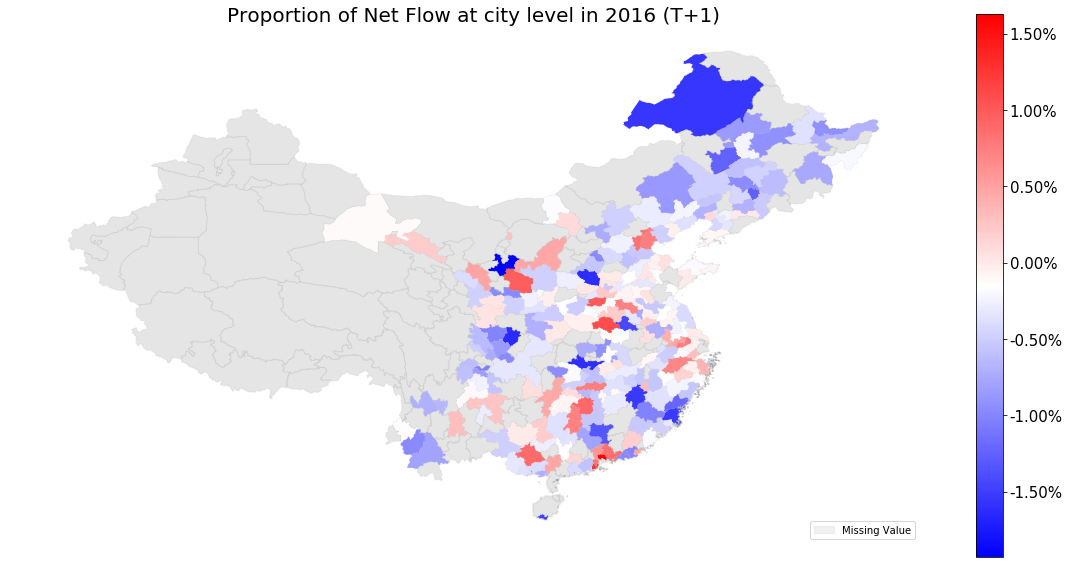

In [19]:
#geographic distribution of Y 

fig, ax = plt.subplots(1,figsize=(20,10))

ax.set_aspect('equal')

map_df.plot(ax=ax, color='black',linewidth=1, edgecolor="grey",alpha=0.1)

grey_patch = mpatches.Patch(color='grey', alpha=0.1,label='Missing Value')

plt.legend(handles=[grey_patch],loc="lower right")

merged.plot(ax=ax, column="Net_Flow_T+1",cmap='bwr',legend=True)

colourbar = ax.get_figure().get_axes()[1]

yticks = colourbar.get_yticks()

ax.get_figure().set_size_inches(20,10)

colourbar.set_yticklabels(['{0:.2f}%'.format(ytick) for ytick in yticks], fontdict={"fontsize": "15"})

ax.set_title('Proportion of Net Flow at city level in 2016 (T+1)', \
              fontdict={'fontsize': '20',
                        'fontweight' : '3'})
ax.axis('off')


<h3>2. Correlation Matrix</h3>

In [20]:
corr= df.drop(["City_Name","Year_T","Net_Flow_T+1"],axis=1).corr() #show the correlation between each X feature pair in table

corr

,Unempl_Rate,Prop_in_Sec_Ind,Pop_Density,GRP,GRP_Growth,Prop_of_Sci_Exp,Prop_of_Edu_Exp,Num_of_School,Avg_Income
Unempl_Rate,1.000000,-0.058731,-0.121641,-0.168738,-0.024513,0.005188,-0.096126,-0.099165,-0.185251
Prop_in_Sec_Ind,-0.058731,1.000000,0.227118,0.240384,-0.068731,0.012269,-0.048111,0.093912,0.249610
Pop_Density,-0.121641,0.227118,1.000000,0.347697,0.002717,0.040803,0.035554,0.331892,0.091424
GRP,-0.168738,0.240384,0.347697,1.000000,-0.026037,0.041110,0.065445,0.697924,0.601608
GRP_Growth,-0.024513,-0.068731,0.002717,-0.026037,1.000000,-0.011372,0.026666,-0.000941,-0.045933
Prop_of_Sci_Exp,0.005188,0.012269,0.040803,0.041110,-0.011372,1.000000,-0.559609,0.033947,-0.056200
Prop_of_Edu_Exp,-0.096126,-0.048111,0.035554,0.065445,0.026666,-0.559609,1.000000,-0.090877,0.245515
Num_of_School,-0.099165,0.093912,0.331892,0.697924,-0.000941,0.033947,-0.090877,1.000000,0.303926
Avg_Income,-0.185251,0.249610,0.091424,0.601608,-0.045933,-0.056200,0.245515,0.303926,1.000000


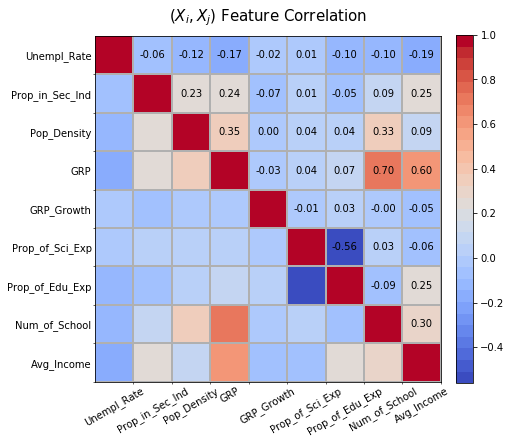

In [21]:
# correlation matrix plot design

fig = plt.figure(figsize=(80,80))
ax1 = fig.add_subplot(10,10,1)
cmap = cm.get_cmap('coolwarm', 30)
cax = ax1.imshow(corr, cmap=cmap)

plt.title( r'$(X_i, X_j)$ Feature Correlation', fontsize="15", pad=15)

labels=list(df.drop(["City_Name","Year_T","Net_Flow_T+1"],axis=1).columns.values)

plt.xticks(np.arange(9), labels, rotation=30)
plt.yticks(np.arange(9), labels)

ax1.xaxis.set_minor_locator(AutoMinorLocator(2))
ax1.yaxis.set_minor_locator(AutoMinorLocator(2))

ax1.tick_params(which='major', length=0)
ax1.tick_params(which="minor", length=2,grid_linewidth=2)

ax1.grid(which="minor")

ax1.set_xticklabels(labels,fontsize=10)
ax1.set_yticklabels(labels,fontsize=10)

colorbar=fig.colorbar(cax,fraction=0.046, pad=0.04)


for i in range(len(labels)):
    for j in range(i,len(labels)):
        if (corr.iat[i,j]>0.7 and corr.iat[i,j]<1) or (corr.iat[i,j]<-0.7 and corr.iat[i,j]>-1):
            text = ax1.text(j, i, '{:,.2f}'.format(corr.iat[i, j]),ha="center", va="center", color="w")
        elif (corr.iat[i,j]<=0.7 and corr.iat[i,j]>=-0.7):
            text = ax1.text(j, i, '{:,.2f}'.format(corr.iat[i, j]),ha="center", va="center", color="Black")

Warm color means positive correlation while cool color means negative correlation. <br>
From the plot, we can tell that multicolinearity is not a big issue for our dataset.

<h3>3. Distribution of X</h3>

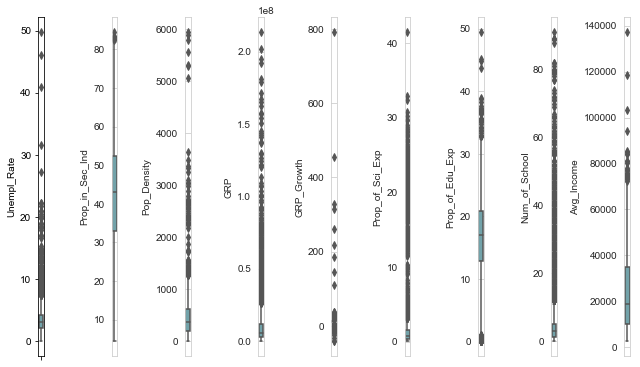

In [22]:
#check the distribution of each X features using boxplot


name_list=list(df.drop(["City_Name","Year_T","Net_Flow_T+1"],axis=1).columns.values) 

col=len(name_list)
row=col-1/col

plt.figure(figsize=(col,5*row))

for i in range(0,len(name_list)):
    plt.subplot(row+1, col, i+1)
    sns.set_style('whitegrid')
    sns.boxplot(df[name_list[i]],color='#69a9b2',orient='v')
    plt.tight_layout()
    

#coding reference to https://towardsdatascience.com/predicting-click-through-rate-for-a-website-7cd2a892d26e

From the above box plot, we can tell that the distribution of <b>"Unempl_Rate", "Pop_Density", "GRP", "GRP_Growth", "Prop_of_Sci_Exp", "Num_of_School" and "Avg_Income" </b> are all right-tailed and there are a lot of outliers.

In [23]:
#scale the data to better fit the model

df["Unempl_Rate"]=np.log(df["Unempl_Rate"])
df["Pop_Density"]=np.log(df["Pop_Density"])
df["GRP"]=np.log(df["GRP"].astype('float'))
df["GRP_Growth"]=np.cbrt(df["GRP_Growth"])  #Since growth rate has negative values, we use cube root.
df['Prop_of_Sci_Exp']=np.cbrt(df['Prop_of_Sci_Exp'])
df["Num_of_School"]=np.cbrt(df["Num_of_School"])  #Since number of school can be 0, we use cube root.
df["Avg_Income"]=np.log(df["Avg_Income"].astype('float'))

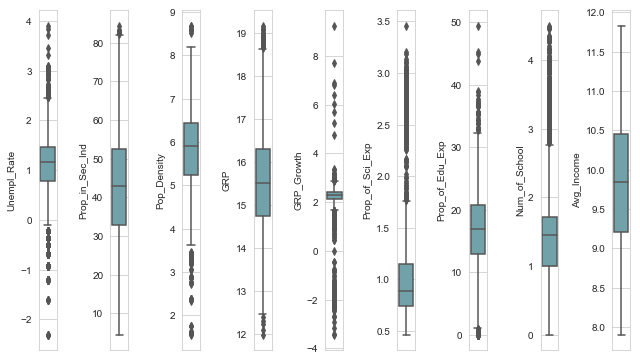

In [24]:
#box plot for scaled variables

name_list=list(df.drop(["City_Name","Year_T","Net_Flow_T+1"],axis=1).columns.values) 

col=len(name_list)
row=col-1/col

plt.figure(figsize=(col,5*row))

for i in range(0,len(name_list)):
    plt.subplot(row+1, col, i+1)
    sns.set_style('whitegrid')
    sns.boxplot(df[name_list[i]],color='#69a9b2',orient='v')
    plt.tight_layout()

#coding reference to https://towardsdatascience.com/predicting-click-through-rate-for-a-website-7cd2a892d26e

<h3>4. X , Y Relationship </h3>

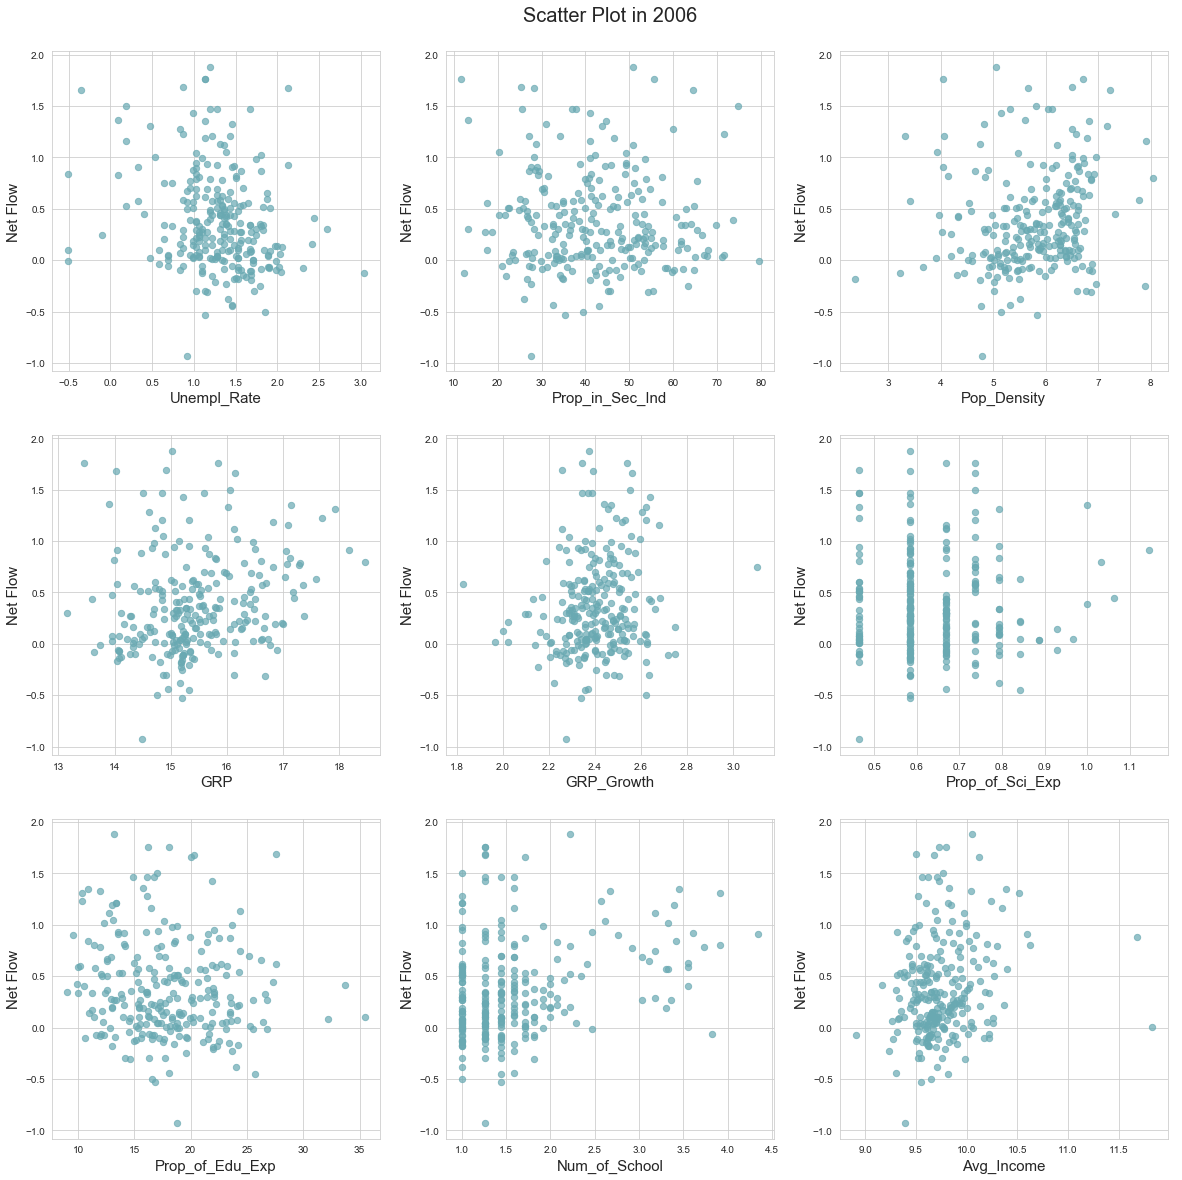

In [25]:
#scatter plot of X & Y relationship in 2006

name_list=list(df.drop(["City_Name","Year_T","Net_Flow_T+1"],axis=1).columns.values) 

fig = plt.figure(figsize=(20,20))

plt.box(on=None)
plt.axis('off')
plt.title("Scatter Plot in 2006",pad=30,fontsize=20)

for i in range(0,len(name_list)):
    
    subplot=fig.add_subplot(3, 3, i+1)
    subplot.scatter(df[df["Year_T"]==2006].iloc[:,i+2],df[df["Year_T"]==2006].iloc[:,11], s=40,c='#69a9b2',
                            alpha=0.7,linewidths=1)
    subplot.set_ylabel("Net Flow", fontsize=15)
    subplot.set_xlabel(name_list[i],fontsize=15)

<h2>C. Train Test Split</h2>

Since the dataset involves <b>time series data</b>, we will use latest year data as the test set and train only on data before that.

In [26]:
#transform City_Name features into dummy variables

Y = df[["Net_Flow_T+1"]].values.ravel()
X = pd.get_dummies(df.drop(columns="Net_Flow_T+1"))

In [27]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, shuffle=False, test_size=0.20, random_state =0)

In [28]:
#the shape of train and test set

print("Original:", X.shape)
print("Train:   ", X_train.shape,Y_train.shape)
print("Test:    ", X_test.shape,Y_test.shape)

Original: (4563, 294)
Train:    (3650, 294) (3650,)
Test:     (913, 294) (913,)


<h2>D. Data Standardization </h2>

In [29]:
#since our model has a lot of outliers, we use robust scaler which is robust to outliers.

#scale X
robust_scaler_X=RobustScaler()
robust_scaler_X=robust_scaler_X.fit(X_train)

X_train = robust_scaler_X.transform(X_train)
X_test  = robust_scaler_X.transform(X_test)


#scale Y
robust_scaler_Y=RobustScaler()
robust_scaler_Y=robust_scaler_Y.fit(Y_train.reshape(-1,1))

Y_train = robust_scaler_Y.transform(Y_train.reshape(-1,1))
Y_test  = robust_scaler_Y.transform(Y_test.reshape(-1,1))




<h2>E. Model Building</h2>

<h3>1. Baseline Setting</h3>

<b>Baseline1:</b> Use the mean of Y_train to predict Y_test.

In [30]:
print("Baseline1 MSE: %.5f" % mean_squared_error(np.ones(Y_test.shape)*np.mean(Y_train), Y_test))

Baseline1 MSE: 1.65194


<b>Baseline2:</b> More Practically, having no predictive power means predict Y as 0 for each city (no migration outflow and inflow).

In [31]:
print("Baseline2 MSE: %.5f" % mean_squared_error(robust_scaler_Y.transform(np.zeros(Y_test.shape)), Y_test))

Baseline2 MSE: 1.32650


<h3>2. SGD Regressor</h3>

In [32]:
# gridSearch to find the parameter with close score in train and validation set

sgd= SGDRegressor(shuffle=False, random_state=0) # no shuffle for time series data

param_dist = {
    "penalty": ["l1", "l2"],
    "alpha": [0.01,0.1,0.5,1],
    "learning_rate": ["constant"],
    "max_iter": [50,100,500,1000]
}

grid_search = GridSearchCV(
    sgd,
    param_dist,
    cv  = TimeSeriesSplit(5),    #use times series split to make sure the time order
    scoring='neg_mean_squared_error',
    return_train_score=True 
)


grid_search.fit(X_train,Y_train.flatten())



GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score='raise-deprecating',
             estimator=SGDRegressor(alpha=0.0001, average=False,
                                    early_stopping=False, epsilon=0.1,
                                    eta0=0.01, fit_intercept=True,
                                    l1_ratio=0.15, learning_rate='invscaling',
                                    loss='squared_loss', max_iter=1000,
                                    n_iter_no_change=5, penalty='l2',
                                    power_t=0.25, random_state=0, shuffle=False,
                                    tol=0.001, validation_fraction=0.1,
                                    verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.01, 0.1, 0.5, 1],
                         'learning_rate': ['constant'],
                         'max_iter': [50, 100, 500, 1000],
                         'penalty': [

In [33]:
#show all the results of grid search

results= grid_search.cv_results_

results= pd.DataFrame({
    "Alpha": results["param_alpha"],
    "Learning_Rate": results["param_learning_rate"],
    "Max_Iter": results["param_max_iter"],
    "Penalty": results["param_penalty"],
    "TrainMSE": -results["mean_train_score"],
    "TestMSE": -results["mean_test_score"]
})

results

,Alpha,Learning_Rate,Max_Iter,Penalty,TrainMSE,TestMSE
0,0.01,constant,50,l1,1.024132,0.914260
1,0.01,constant,50,l2,2.009796,1.644847
2,0.01,constant,100,l1,1.024132,0.914260
3,0.01,constant,100,l2,2.009796,1.644847
4,0.01,constant,500,l1,1.024132,0.914260
5,0.01,constant,500,l2,2.009796,1.644847
6,0.01,constant,1000,l1,1.024132,0.914260
7,0.01,constant,1000,l2,2.009796,1.644847
8,0.1,constant,50,l1,0.973321,0.903700
9,0.1,constant,50,l2,4.258050,2.656663


In [34]:
#choose the parameter in row 24

sgd=SGDRegressor(
    shuffle=False, 
    random_state=0,
    penalty="l1",
    alpha=1,
    learning_rate="constant",
    max_iter=50
)

sgd.fit(X_train,Y_train.flatten())

pred_train=sgd.predict(X_train)
pred_test=sgd.predict(X_test)

mse_train  = mean_squared_error(pred_train, Y_train)
mse_test  = mean_squared_error(pred_test, Y_test)
print("SGDRegressor MSE on train:", mse_train)
print("SGDRegressor MSE on test:", mse_test)


SGDRegressor MSE on train: 1.1308561312418606
SGDRegressor MSE on test: 1.2373114118742918


<h3>3. SVR</h3>

In [35]:
svr=SVR()

parameters={
    "kernel": ["linear","rbf",'poly'],
    "C": [1e-5,1e-4,1e-3],
    "gamma": [0.001,0.01],
    "tol": [0.1,1],
    "epsilon": [0]
}


grid_search = GridSearchCV(
    svr, 
    parameters,
    cv = TimeSeriesSplit(5),    
    scoring='neg_mean_squared_error',
    return_train_score=True 
)

grid_search.fit(X_train,Y_train.flatten())




GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score='raise-deprecating',
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto_deprecated', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [1e-05, 0.0001, 0.001], 'epsilon': [0],
                         'gamma': [0.001, 0.01],
                         'kernel': ['linear', 'rbf', 'poly'], 'tol': [0.1, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_squared_error', verbose=0)

In [36]:
results= grid_search.cv_results_

results= pd.DataFrame({
    "C": results["param_C"],
    "epsilon": results["param_epsilon"],
    "gamma": results["param_gamma"],
    "kernel": results["param_kernel"],
    "tol": results["param_tol"],
    "TrainMSE": -results["mean_train_score"],
    "TestMSE": -results["mean_test_score"]
})

results

,C,epsilon,gamma,kernel,tol,TrainMSE,TestMSE
0,1e-05,0,0.001,linear,0.1,0.982465,0.952623
1,1e-05,0,0.001,linear,1,1.047836,0.983256
2,1e-05,0,0.001,rbf,0.1,0.988556,0.956142
3,1e-05,0,0.001,rbf,1,1.052879,0.988114
4,1e-05,0,0.001,poly,0.1,0.990488,0.956583
5,1e-05,0,0.001,poly,1,1.196163,1.090802
6,1e-05,0,0.01,linear,0.1,0.982465,0.952623
7,1e-05,0,0.01,linear,1,1.047836,0.983256
8,1e-05,0,0.01,rbf,0.1,0.988172,0.956299
9,1e-05,0,0.01,rbf,1,1.037099,0.982919


In [37]:
#choose the parameter in row 29

svr=SVR(
    
    kernel="poly",
    C=1e-3,
    tol=1,
    gamma=0.001,
    epsilon=0
)

svr.fit(X_train,Y_train.flatten())

pred_test=svr.predict(X_test)
pred_train=svr.predict(X_train)

mse_train = mean_squared_error(pred_train, Y_train)
mse_test  = mean_squared_error(pred_test, Y_test)

print("SVR train MSE:", mse_train)
print("SVR test MSE:", mse_test)


SVR train MSE: 1.147126603184616
SVR test MSE: 1.22660643304887


<h3>4. Random Forest</h3>

In [38]:
parameters={
    "n_estimators": [1,2,3,4,5,10],
    "max_depth": [1,2,5,7,10],
    "max_features": ("auto", "log2", "sqrt"),
    "min_samples_split": [10,100,200,300]
}
regr=RandomForestRegressor(bootstrap=False, random_state=0)

grid_search=GridSearchCV(
    regr, 
    parameters,
    cv=TimeSeriesSplit(5),
    return_train_score=True,
    scoring="neg_mean_squared_error")

grid_search.fit(X_train,Y_train.flatten())

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=False, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=0,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None

In [39]:
results= grid_search.cv_results_

results= pd.DataFrame({
    "n_estimators": results["param_n_estimators"],
    "max_depth": results["param_max_depth"],
    "max_features": results["param_max_features"],
    "min_samples_split": results["param_min_samples_split"],
    "TrainMSE": -results["mean_train_score"],
    "TestMSE": -results["mean_test_score"]
})

results.head()

,n_estimators,max_depth,max_features,min_samples_split,TrainMSE,TestMSE
0,1,1,auto,10,0.875412,0.923682
1,2,1,auto,10,0.875412,0.923682
2,3,1,auto,10,0.875412,0.923682
3,4,1,auto,10,0.875412,0.923682
4,5,1,auto,10,0.875412,0.923682


In [40]:
regr=RandomForestRegressor(
    
    random_state=0,  
    bootstrap=False, 
    max_depth=2, 
    min_samples_split=300,
    n_estimators=2,
    max_features="auto"
)

regr.fit(X_train,Y_train.flatten())


pred_train=regr.predict(X_train)
pred_test=regr.predict(X_test)

mse_train = mean_squared_error(pred_train, Y_train)
mse_test  = mean_squared_error(pred_test, Y_test)

print("RandomForest train MSE:", mse_train)
print("RandomForest test MSE:", mse_test)

#overfit

RandomForest train MSE: 0.8404499523972383
RandomForest test MSE: 1.1294596140803168


<h3>5. Neural Network</h3>

In [43]:
model = models.Sequential()

model.add(layers.Dense(32,  kernel_regularizer = regularizers.l2(0.001),activation = 'relu', input_dim = 294))

model.add(layers.Dense(16,  kernel_regularizer = regularizers.l2(0.001),activation = 'relu'))

model.add(layers.Dense(1, kernel_regularizer = regularizers.l2(0.001),activation = 'sigmoid'))


rmsprop = optimizers.RMSprop(learning_rate=0.0000001)
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics = ['accuracy'])

In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                9440      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 9,985
Trainable params: 9,985
Non-trainable params: 0
_________________________________________________________________


In [45]:
history = model.fit(X_train, Y_train, epochs = 100, 
                 verbose = 1,validation_data = (X_test, Y_test) )

Train on 3650 samples, validate on 913 samples
Epoch 1/100
3650/3650 [==============================] - 1s 342us/sample - loss: 0.4074 - accuracy: 0.0088 - val_loss: -1.3009 - val_accuracy: 0.0066
Epoch 2/100
3650/3650 [==============================] - 0s 48us/sample - loss: -4.0726e-04 - accuracy: 0.0085 - val_loss: -3.2987 - val_accuracy: 0.0066
Epoch 3/100
3650/3650 [==============================] - 0s 50us/sample - loss: -0.3691 - accuracy: 0.0085 - val_loss: -6.1402 - val_accuracy: 0.0066
Epoch 4/100
3650/3650 [==============================] - 0s 50us/sample - loss: -0.8776 - accuracy: 0.0096 - val_loss: -10.3058 - val_accuracy: 0.0066
Epoch 5/100
3650/3650 [==============================] - 0s 49us/sample - loss: -1.6552 - accuracy: 0.0096 - val_loss: -16.8914 - val_accuracy: 0.0066
Epoch 6/100
3650/3650 [==============================] - 0s 51us/sample - loss: -2.7926 - accuracy: 0.0093 - val_loss: -26.3749 - val_accuracy: 0.0066
Epoch 7/100
3650/3650 [=======================

In [46]:
Y_test_predict= model.predict(X_test)
Y_train_predict= model.predict(X_train)

mse_test  = mean_squared_error(Y_test_predict, Y_test)
mse_train  = mean_squared_error(Y_train_predict, Y_train)

print("Neural Network train MSE:", mse_train)
print("Neural Network test MSE:" , mse_test)

Neural Network train MSE: 0.8599478935349678
Neural Network test MSE: 1.5470509536266777


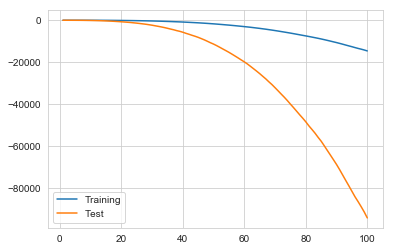

In [47]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, label = "Training")
plt.plot(epochs, val_loss, label = "Test")
plt.legend()
plt.savefig("loss_overfit.png")

<h3> 6. The Best Model</h3>

Comparing with two baselines and other models, we decide to choose the <b>SGD Regressor</b>, which improves baseline1 by 25.13% and baseline2 by 6.72%.